# Analysis of sequence and p

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

## An example for debugging

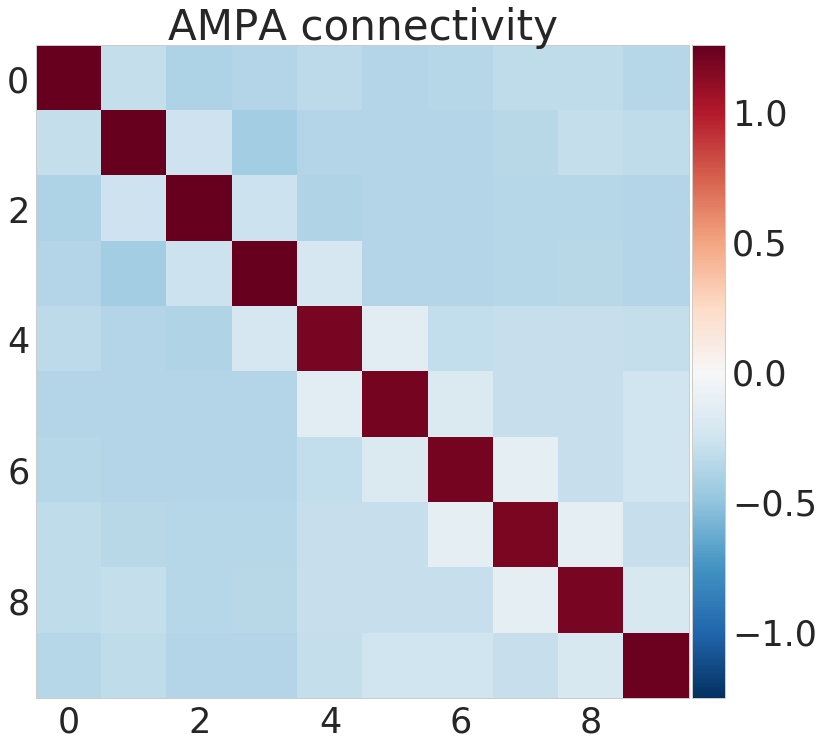

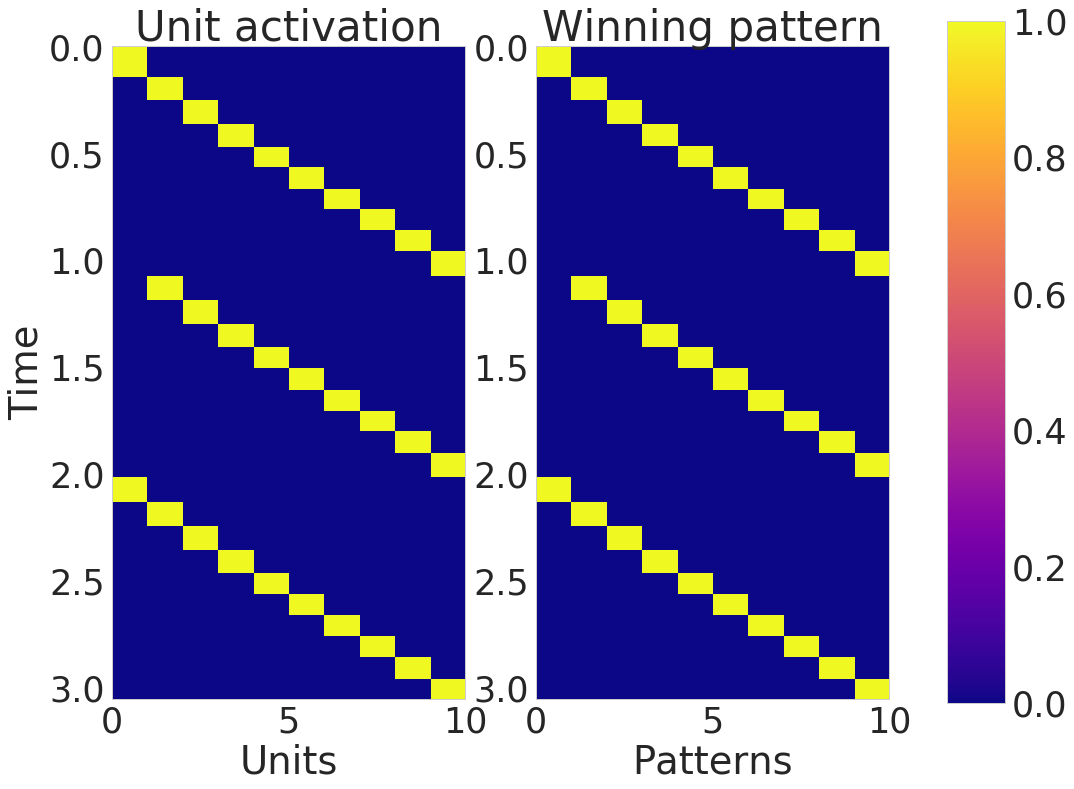

In [34]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.050
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050


nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

manager.run_network_protocol(protocol=protocol, verbose=False)
sequences = [patterns_indexes]
aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux

plot_weight_matrix(manager.nn, ampa=True)
plot_network_activity_angle(manager)

Let's extract the next column, the difference between the second the one before the last column, the rest fr the two, the standard deviation

In [26]:
second_index = 1
last_index = n_patterns - 2

w_next_second = nn.w_ampa[second_index + 1, second_index]
w_rest_second_mean = nn.w_ampa[(second_index + 2):, second_index].mean()
w_rest_second_std = nn.w_ampa[(second_index + 2):, second_index].std()

w_next_last = nn.w_ampa[last_index + 1, last_index]
w_rest_last_mean = nn.w_ampa[:last_index, last_index].mean()
w_rest_last_std = nn.w_ampa[:last_index, last_index].std()

In [27]:
nn.w_ampa[:, last_index]

array([-0.28, -0.3 , -0.27, -0.3 , -0.22, -0.26, -0.22, -0.12,  0.  , -0.14])

In [28]:
nn.w_ampa[:last_index, last_index]

array([-0.28, -0.3 , -0.27, -0.3 , -0.22, -0.26, -0.22, -0.12])

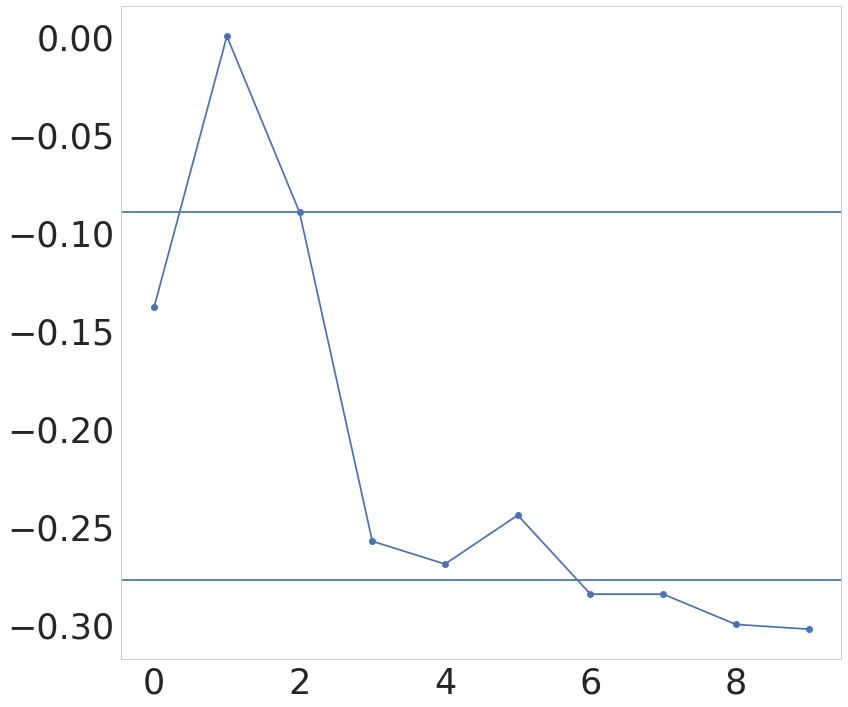

In [32]:
plt.plot(nn.w_ampa[:, second_index], 'o-')
plt.axhline(w_next_second)
plt.axhline(w_rest_second_mean)

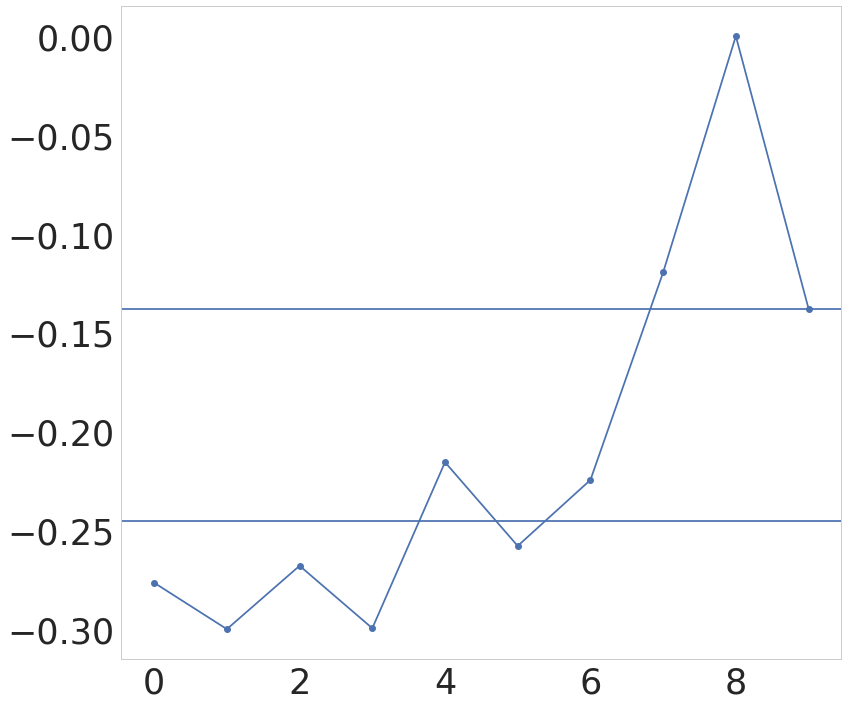

In [33]:
plt.plot(nn.w_ampa[:, last_index], 'o-')
plt.axhline(w_next_last)
plt.axhline(w_rest_last_mean)

## Systematic

In [51]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

second_index = 1
last_index = n_patterns - 2

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.050
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 50

tau_p_values = np.linspace(5, 100, num=num)

successes = np.zeros_like(tau_p_values)
persistent_times = np.zeros_like(tau_p_values)

w_next_second_vector = np.zeros_like(tau_p_values)
w_rest_second_mean_vector = np.zeros_like(tau_p_values)
w_rest_second_std_vector = np.zeros_like(tau_p_values)

w_next_last_vector = np.zeros_like(tau_p_values)
w_rest_last_mean_vector = np.zeros_like(tau_p_values)
w_rest_last_std_vector = np.zeros_like(tau_p_values)

for index, tau_p in enumerate(tau_p_values):
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    manager.run_network_protocol(protocol=protocol, verbose=False)
    sequences = [patterns_indexes]
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    persistent_times[index] = mean
    successes[index] = success

    w_next_second_vector[index] = nn.w_ampa[second_index + 1, second_index]
    w_rest_second_mean_vector[index] = nn.w_ampa[(second_index + 2):, second_index].mean()
    w_rest_second_std_vector[index] = nn.w_ampa[(second_index + 2):, second_index].std()

    w_next_last_vector[index] = nn.w_ampa[last_index + 1, last_index]
    w_rest_last_mean_vector[index] = nn.w_ampa[:last_index, last_index].mean()
    w_rest_last_std_vector[index] = nn.w_ampa[:last_index, last_index].std()

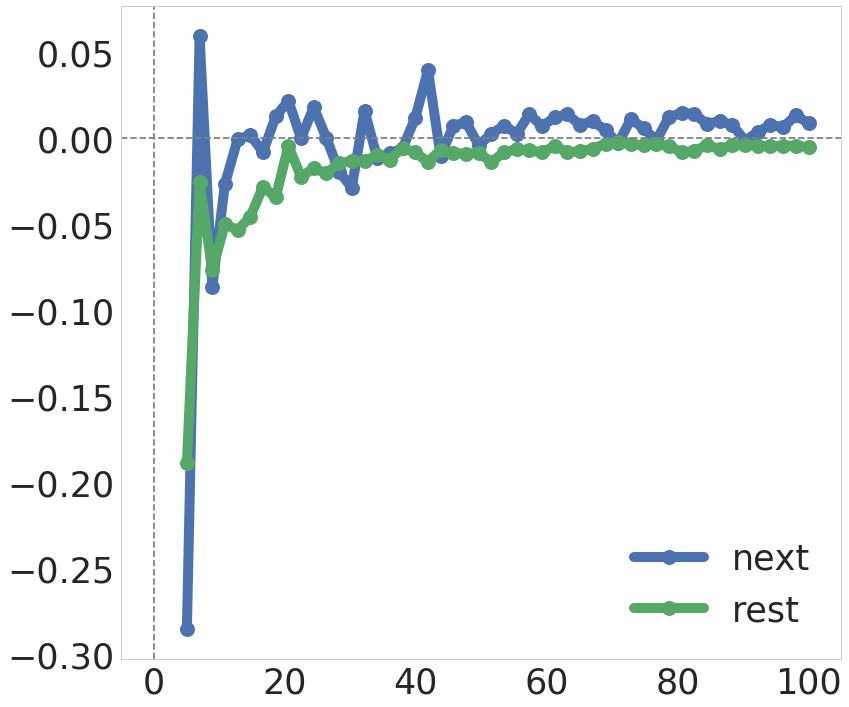

In [52]:
next_difference = w_next_second_vector - w_next_last_vector
rest_difference = w_rest_second_mean_vector - w_rest_last_mean_vector

markersize = 15
linewidth = 10

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tau_p_values, next_difference, 'o-', markersize=markersize, lw=linewidth, label=r'next')
ax.plot(tau_p_values, rest_difference, 'o-', markersize=markersize, lw=linewidth, label='rest')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

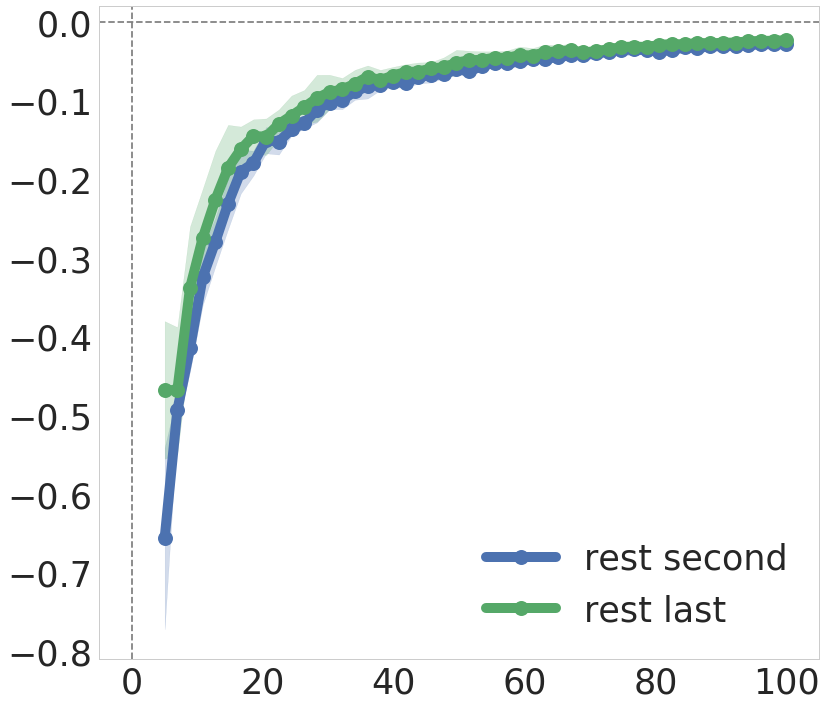

In [54]:
color_palette = sns.color_palette()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tau_p_values, w_rest_second_mean_vector, 'o-', markersize=markersize, 
        lw=linewidth, color=color_palette[0], label=r'rest second')
ax.plot(tau_p_values, w_rest_last_mean_vector, 'o-', markersize=markersize, 
        lw=linewidth, color=color_palette[1], label='rest last')

ax.fill_between(tau_p_values, w_rest_second_mean_vector - w_rest_second_std_vector, 
                 w_rest_second_mean_vector + w_rest_second_std_vector,
                 color=current_palette[0], alpha=0.25)

ax.fill_between(tau_p_values, w_rest_last_mean_vector - w_rest_last_std_vector, 
                 w_rest_last_mean_vector + w_rest_last_std_vector,
                 color=current_palette[1], alpha=0.25)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();